# Signal Separator

This notebook loads N audio signals which are mixed recordings of M=N audio sources, synchronizes their beginnings, and tries to reconstruct the original source signals using ICA.

**Input**: paths of WAV files (see "files" variable below). Files can be converted to WAV online, e.g. [here](https://audio.online-convert.com/convert-to-wav).

**Inline audio player**: to enable inline audio player, notebook should be opened using:

    jupyter notebook --NotebookApp.iopub_data_rate_limit=30000000

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import pickle as pkl
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
from PIL import Image
import librosa
import IPython.display as ipd
from sklearn.decomposition import FastICA

In [2]:
DATA = Path('Data/Recordings_1')
files = ('Galaxy_S8_20190614112028','Mi_A2_20190614110933','Redmi_note_20190614110921')
layout_sources = ('Recordings_layout_marked.jpg', 'Recordings_layout.jpg')

INLINE_PLAYER = False

In [4]:
N = len(files)
T0 = time()

## Recording Layout

Layout image unavailable.


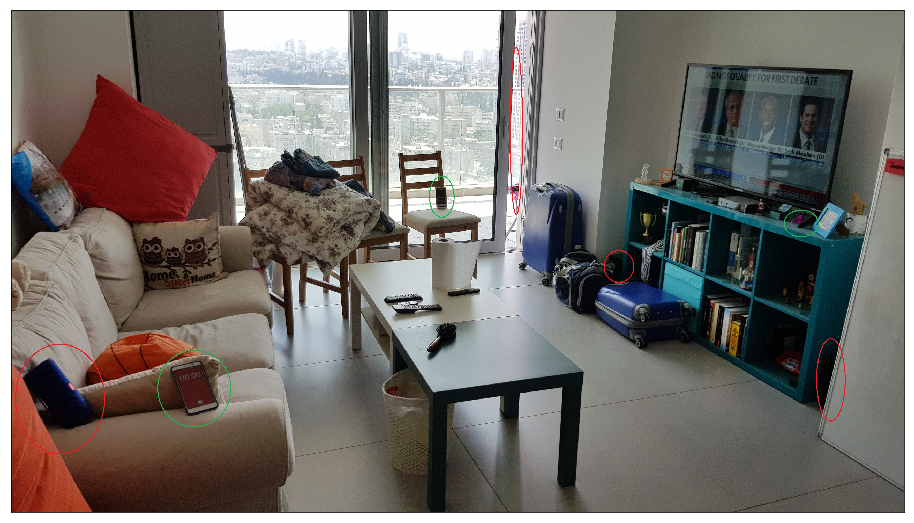

In [5]:
source_found = False
for ls in layout_sources:
    if os.path.isfile(DATA/ls):
        plt.figure(figsize=(16,10))
        plt.imshow(np.asarray(Image.open(DATA/ls)))
        plt.xticks(())
        plt.yticks(())
        break

if not source_found:
    print('Layout image unavailable.')

## Load and Show Signals

In [6]:
# read audio files
signals = {}
for file in files:
    nm = file[:-15]
    y, sr = librosa.load(DATA/(file+'.wav'))
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    signals[nm] = {'y':y, 'sr':sr, 'tempo':tempo, 'beat_frames':beat_frames}
    print(f'{nm:s}:\tlen = {len(y):d};\tsample_rate = {sr:f};\tbeats per minute = {tempo:.2f}.')

Galaxy_S8:	len = 5994496;	sample_rate = 22050.000000;	beats per minute = 123.05.
Mi_A2:	len = 5300352;	sample_rate = 22050.000000;	beats per minute = 92.29.
Redmi_note:	len = 5336541;	sample_rate = 22050.000000;	beats per minute = 123.05.


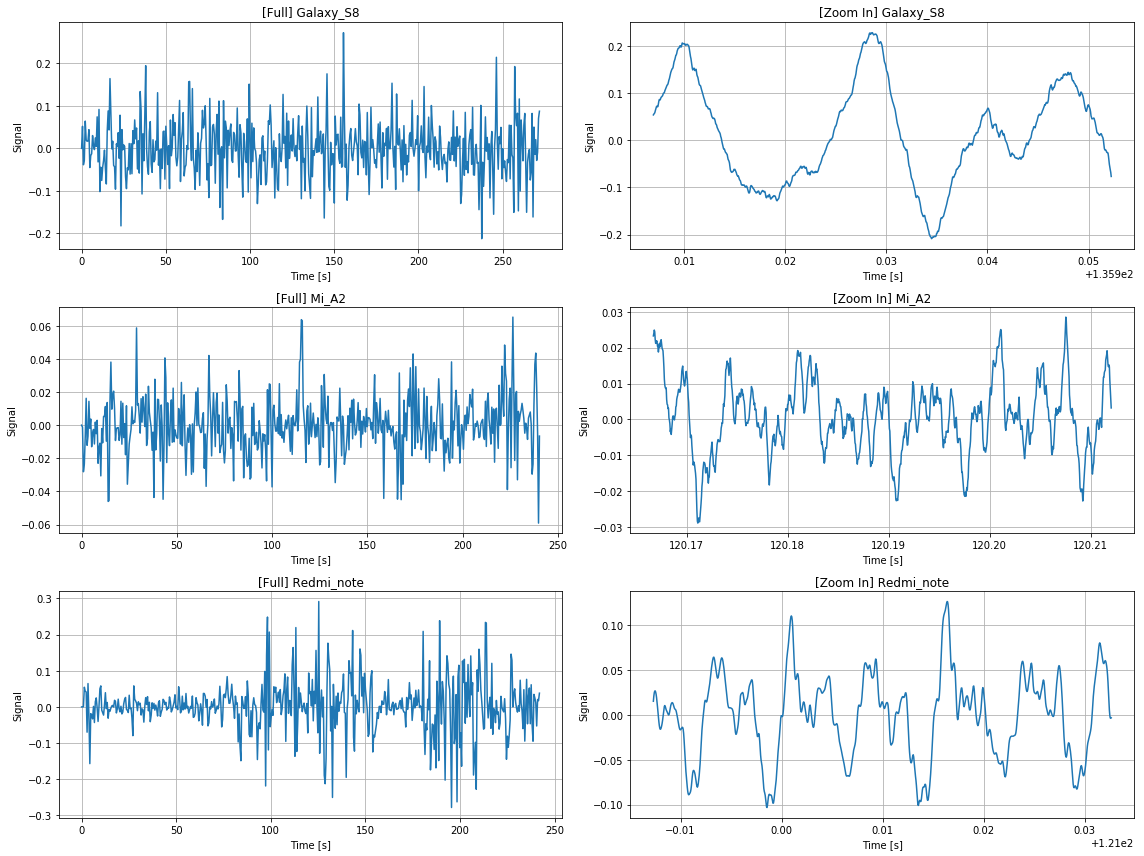

In [7]:
# show raw signals

_, axs = plt.subplots(N,2, figsize=(16,4*N))

for i,sig in enumerate(signals):
    y = signals[sig]['y']
    
    ax = axs[i,0]
    t = range(0,len(y),len(y)//500)
    ax.plot(np.array(list(t))/sr, y[t])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Signal')
    ax.set_title(f'[Full] {sig:s}')
    ax.grid()
    
    ax = axs[i,1]
    t = range(len(y)//2-500,len(y)//2+500)
    ax.plot(np.array(list(t))/sr, y[t])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Signal')
    ax.set_title(f'[Zoom In] {sig:s}')
    ax.grid()

plt.tight_layout()

In [3]:
if INLINE_PLAYER:
    file = files[0]
    print(file)
player = ipd.Audio(str(DATA/(file+'.wav'))) if INLINE_PLAYER else None
player

In [4]:
if INLINE_PLAYER:
    file = files[1]
    print(file)
player = ipd.Audio(str(DATA/(file+'.wav'))) if INLINE_PLAYER else None
player

In [5]:
if INLINE_PLAYER:
    file = files[2]
    print(file)
player = ipd.Audio(str(DATA/(file+'.wav'))) if INLINE_PLAYER else None
player

## Sync Signals

In [11]:
Y = [signals[sig]['y'] for sig in signals]

A Jupyter Widget


Sync offsets [s]:
[0.0, -19.91, -6.92]


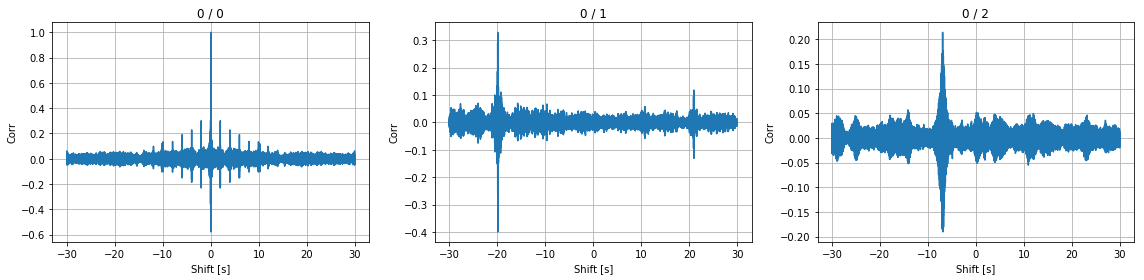

In [12]:
shift_max = sr * 30
shift_step = 10
mask_len = sr * 30
mask_base = sr * 120

def corr(i, j, shift):
    # certainly can be done more elegantly; however, naively using np.corrcoef()[0,1] or np.convolve() was very slow.
    yi = Y[i][mask_base+max(0,-shift) : mask_base+max(0,-shift)+mask_len]
    yj = Y[j][mask_base+max(0, shift) : mask_base+max(0, shift)+mask_len]
    return np.correlate(yi,yj) / np.sqrt(np.matmul(yi,yi)*np.matmul(yj,yj))

_, axs = plt.subplots(1,N, figsize=(16,4))

shifts = range(-shift_max, shift_max, shift_step)
i = 0
cnvs = []
for j in tnrange(N):
    cnvs.append([corr(i,j,shift) for shift in shifts])
    ax = axs[j]
    ax.plot(np.array(list(shifts))/sr, cnvs[-1])
    ax.set_xlabel('Shift [s]')
    ax.set_ylabel('Corr')
    ax.set_title(f'{i:d} / {j:d}')
    ax.grid()

plt.tight_layout()

offsets = [shifts[np.argmax(cnv)] for cnv in cnvs]
print('Sync offsets [s]:')
print([np.round(off/sr,2) for off in offsets])

In [13]:
start = sr * 80
Ysync = [y[start+off:] for y,off in zip(Y,offsets)]
length = np.min([len(y) for y in Ysync])
Ysync = [y[:length] for y in Ysync]
print(length)

3725031


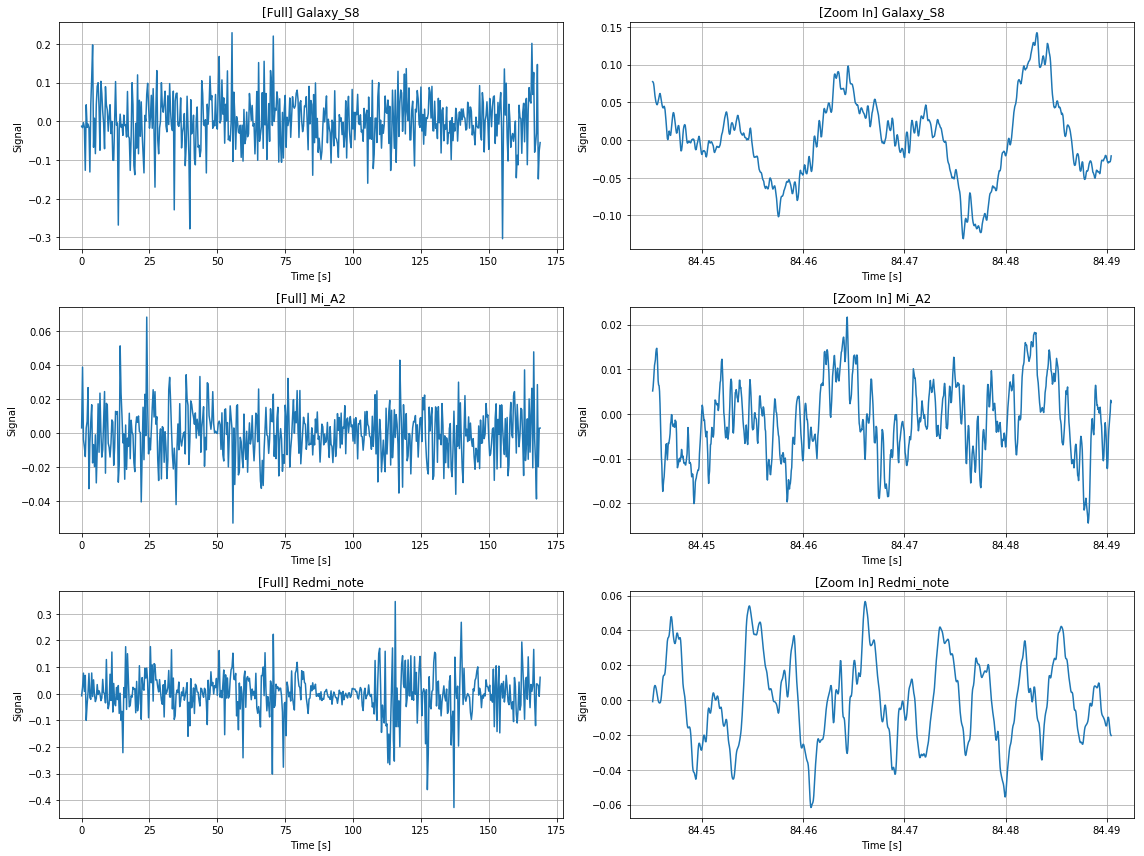

In [14]:
# show synced signals

_, axs = plt.subplots(N,2, figsize=(16,4*N))

for i,(y,sig) in enumerate(zip(Ysync,signals)):
    ax = axs[i,0]
    t = range(0,len(y),len(y)//500)
    ax.plot(np.array(list(t))/sr, y[t])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Signal')
    ax.set_title(f'[Full] {sig:s}')
    ax.grid()
    
    ax = axs[i,1]
    t = range(len(y)//2-500,len(y)//2+500)
    ax.plot(np.array(list(t))/sr, y[t])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Signal')
    ax.set_title(f'[Zoom In] {sig:s}')
    ax.grid()

plt.tight_layout()

In [15]:
for file, y in zip(files,Ysync):
    librosa.output.write_wav(DATA/(file+'_synced'+'.wav'), y, sr)

## Independent Component Analysis

In [16]:
X = np.c_[Ysync].transpose()
X.shape

(3725031, 3)

In [17]:
ica = FastICA(n_components=N)
S = ica.fit_transform(X)
ica_transformation = ica.mixing_

print(S.shape)
print(ica_transformation)

(3725031, 3)
[[  9.86963733 119.579092    33.08352068]
 [ -0.5582115   13.17412738 -27.46206476]
 [151.55308649   5.70286309  -2.68589469]]


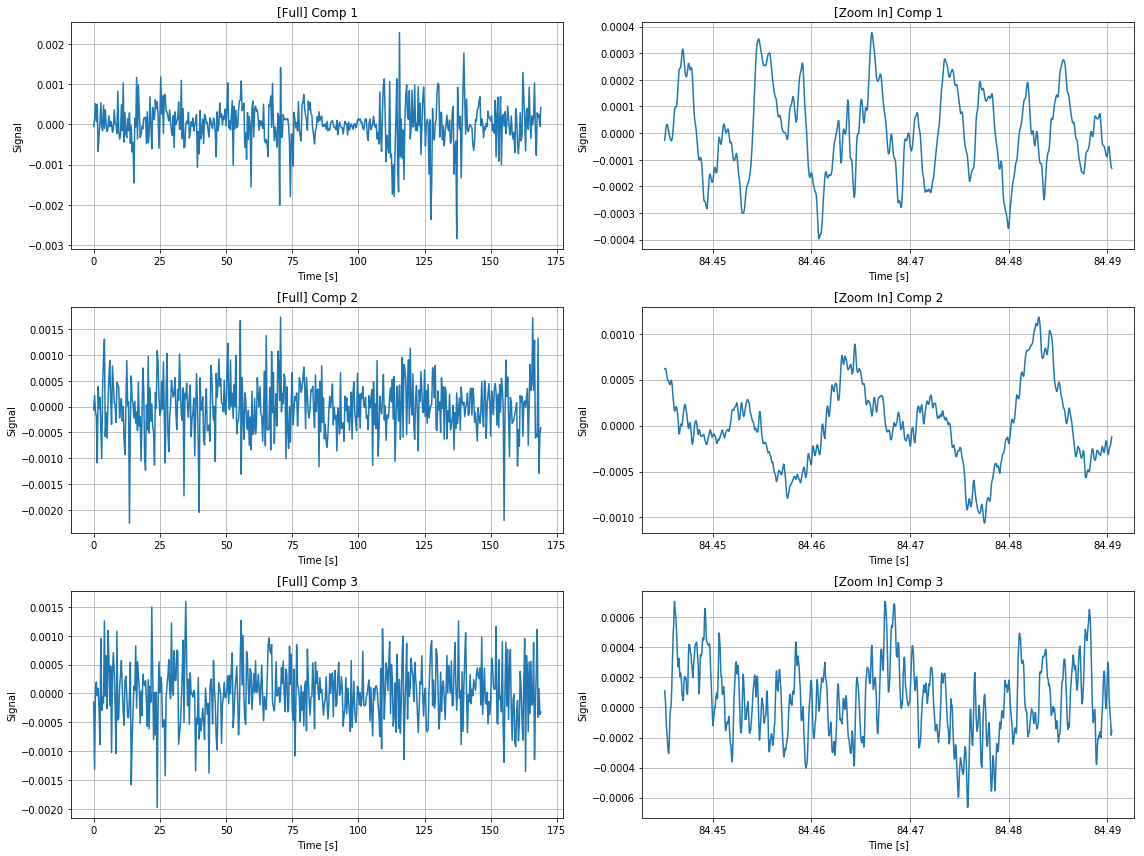

In [18]:
# show separated signals

_, axs = plt.subplots(N,2, figsize=(16,4*N))

for i,sig in enumerate(('Comp 1','Comp 2','Comp 3')):
    y = S[:,i]
    
    ax = axs[i,0]
    t = range(0,len(y),len(y)//500)
    ax.plot(np.array(list(t))/sr, y[t])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Signal')
    ax.set_title(f'[Full] {sig:s}')
    ax.grid()
    
    ax = axs[i,1]
    t = range(len(y)//2-500,len(y)//2+500)
    ax.plot(np.array(list(t))/sr, y[t])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Signal')
    ax.set_title(f'[Zoom In] {sig:s}')
    ax.grid()

plt.tight_layout()

In [19]:
for i in range(N):
    y = np.array(100*S[:,i], dtype=np.float32)
    librosa.output.write_wav(DATA/f'Comp_{i:d}.wav', y, sr, norm=True)

In [6]:
player = ipd.Audio(str(DATA/f'Comp_{0:d}.wav')) if INLINE_PLAYER else None
player

In [7]:
player = ipd.Audio(str(DATA/f'Comp_{1:d}.wav')) if INLINE_PLAYER else None
player

In [8]:
player = ipd.Audio(str(DATA/f'Comp_{2:d}.wav')) if INLINE_PLAYER else None
player

In [23]:
print(f'Total running time:\t{time()-T0}')

Total running time:	139.29110741615295
